In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

In [20]:
PARAMETERS = [0.2, 1, 0.5, 10.0]  # mu_max, Ks, Yxs, Sin

# Αρχικές συνθήκες
X0 = 0.05
S0 = 10.0
V0 = 1.0
F0 = 0.05

# Discretization Step
h = 0.1
# MPC Step
dt = 1

# Simulation Steps
A_s = 100
A_t = int(A_s * dt) # Absolute time

# Prediction and control horizon
Np = 10
Nc = 3

# Bounds on feed rate
F_min = 0.0
F_max = 2.0
bnds = [(F_min, F_max) for _ in range(Np)]


In [21]:
# Ορισμός του setpoint ως συνάρτηση του χρόνου
def Cb_set(t):
    if t < 40:
        return 3
    else:
        return 5

In [22]:
def plant_model(t, y, F):
    X, S, V = y
    mu_max, Ks, Yxs, Sin = PARAMETERS
    dX_dt = (mu_max * S / (Ks + S)) * X - (F / V) * X
    dS_dt = -(1 / Yxs) * (mu_max * S / (Ks + S)) * X + (F / V) * (Sin - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


ValueError: x and y must have same first dimension, but have shapes (101,) and (100,)

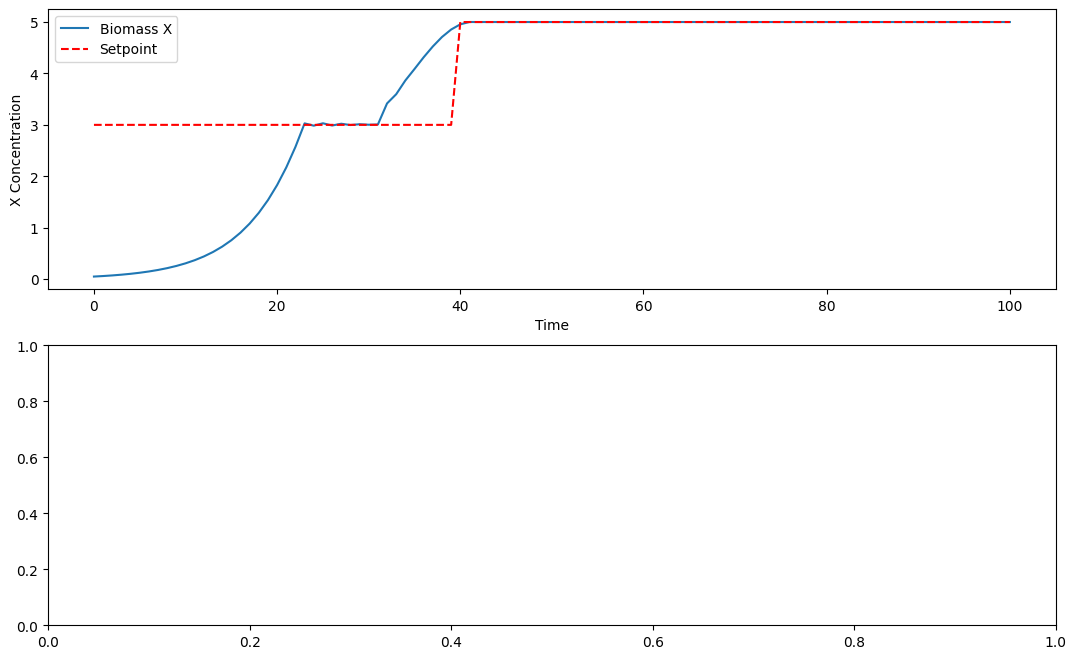

In [23]:
# Διακριτοποιημένο Μοντέλο
def discrete_model(X, S, V, F,h):
    k1 = plant_model(t, [X, S, V], F)
    k2 = plant_model(t + h / 2, [X + k1[0] * h / 2, S + k1[1] * h / 2, V + k1[2] * h / 2], F)
    k3 = plant_model(t + h / 2, [X + k2[0] * h / 2, S + k2[1] * h / 2, V + k2[2] * h / 2], F)
    k4 = plant_model(t + h, [X + k3[0] * h, S + k3[1] * h, V + k3[2] * h], F)

    X_next = X + (h / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    S_next = S + (h / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    V_next = V + (h / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    return X_next, S_next, V_next

# Ορισμός συνάρτησης Κόστους για το MPC
def cost_function(F_opt, X, S, V, t, Q=0.5, R=3):
    J = 0
    X_curr, S_curr, V_curr = X, S, V

    for k in range(Np):
        Cb = Cb_set(t+k)
        X_next, S_next, V_next = discrete_model(X_curr, S_curr, V_curr, F_opt[k], h)
        J += Q * (Cb-X_next) ** 2  # Tracking error

        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2  # Penalization of fast input changes

        X_curr, S_curr, V_curr = X_next, S_next, V_next

    return J

# Προσομοίωση του συστήματος
X = np.ones(A_s + 1)
S = np.ones(A_s + 1)
V = np.ones(A_s + 1)
F = np.ones(A_s)
X[0], S[0], V[0] = X0, S0, V0

for t in tqdm(range(A_s)):
    # Βελτιστοποίηση του MPC
    res = minimize(
        cost_function,
        F0 * np.ones(Np),
        args=(X[t], S[t], V[t], t),
        bounds=bnds,
        method="SLSQP"
    )

    # Επιλογή της πρώτης τιμής της βέλτιστης εισόδου
    F_MPC = res.x[0]

    # Ενημέρωση του συστήματος με επίλυση της διαφορικής εξίσωσης
    sol = solve_ivp(
        plant_model,
        t_span=(t, t + dt),
        y0=[X[t], S[t], V[t]],
        args=(F_MPC,)
    )

    X[t + 1], S[t + 1], V[t + 1] = sol.y[:, -1]
    F[t] = F_MPC

# Σχεδίαση Αποτελεσμάτων
plt.figure(figsize=(13, 8))
plt.subplot(2,1,1)
plt.plot(range(A_s + 1), X, label="Biomass X")
plt.plot(range(A_s + 1), [Cb_set(t) for t in range(A_s + 1)], "r--", label="Setpoint")
plt.xlabel("Time")
plt.ylabel("X Concentration")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(A_s + 1), F, label="Feed Flow Rate F")
plt.xlabel("Time")
plt.ylabel("F")
plt.legend()

plt.show()

In [26]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

t_points = np.arange(0, A_s, dt)
F_func = interp1d(t_points, F, kind="linear", fill_value="extrapolate")

def plant_model(t, y):
    X, S, V = y
    F = F_func(t)
    mu_max, Ks, Yxs, Sin = PARAMETERS
    dX_dt = (mu_max * S / (Ks + S)) * X - (F / V) * X
    dS_dt = -(1 / Yxs) * (mu_max * S / (Ks + S)) * X + (F / V) * (Sin - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

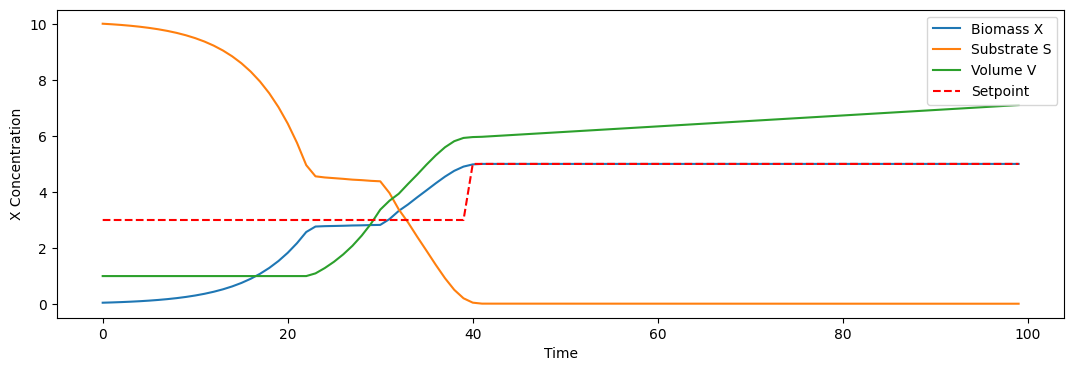

In [27]:
t_span = (0, A_s)
y0 = [X0, S0, V0]
times = np.arange(0, A_s, dt)
sol_t = [0]
sol_X = [X0]
sol_S = [S0]
sol_V = [V0]

for i in range(len(times)-1):
    sol = solve_ivp(plant_model, [times[i], times[i+1]], y0, method='RK45')
    y0 = sol.y[:, -1] # Update initial condition
    sol_t.append(times[i+1])
    sol_X.append(y0[0])
    sol_S.append(y0[1])
    sol_V.append(y0[2])
    
sol_t = np.array(sol_t)
sol_X = np.array(sol_X)
sol_S = np.array(sol_S)
sol_V = np.array(sol_V)

plt.figure(figsize=(13, 4))
plt.plot(sol_t, sol_X, label="Biomass X")
plt.plot(sol_t, sol_S, label="Substrate S")
plt.plot(sol_t, sol_V, label="Volume V")
plt.plot(sol_t, [Cb_set(t) for t in sol_t], "r--", label="Setpoint")
plt.xlabel("Time")
plt.ylabel("X Concentration")
plt.legend()
plt.show()
